# EvolvePy Example 3 - Dynamic mutation

With dynamic mutation, you can prevent the algorithm from getting stuck in some local maximum, and also allow it to fine-tune to some maximum.

- Callbacks
- Using dynamic mutation.

In [2]:
try:
    import evolvepy
except:
    import sys
    sys.path.append("..\src")
import evolvepy

import numpy as np
from matplotlib import pyplot as plt

# Fitness function

This time, we will use a fitness function with 3 sequential increasing peaks:

![Figure1](Example3-Figure1.jpg)

In [45]:
from evolvepy.evaluator import FunctionEvaluator

def fitness_function(individuals):
    individual = individuals[0]["chr0"][0] 

    score = 0

    if individual < 500:
        score = individual
    elif individual < 1000:
        score = 1000 - individual
    elif individual < 2000:
        score = individual - 1000
    elif individual < 3000:
        score = 3000 - individual
    elif individual < 4000:
        score = 2.0*(individual - 3000)
    else:
        score = 2.0*(5000-individual)

    return score

evaluator = FunctionEvaluator(fitness_function)

# Simple experiment

Let's define a simple EA to optimize our function, with an additional detail: let's set the initial generation to be in the range between -500 and 500:

In [54]:
from evolvepy.generator import Generator, CombineLayer
from evolvepy.generator.mutation import NumericMutationLayer, sum_mutation
from evolvepy.generator.crossover import one_point
from evolvepy.generator.selection import tournament
from evolvepy import Evolver


# Defines the layers of the generator
layers = [CombineLayer(tournament, one_point), NumericMutationLayer(sum_mutation, 1.0, 0.0, (-10.0, 10.0))]

# Creates the generator, specifying that an individual has only one chromosome, which can vary between -1000 and 4000 
generator = Generator(1, layers, (-500.0, 500.0))


# Here we specify for Evolver to use the generator and evaluator, in generations of 100 individuals.
evolver = Evolver(generator, evaluator, 100)

Let's evolve our generation:

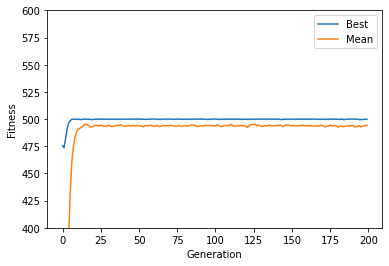

In [55]:
hist, last_population = evolver.evolve(200) 

plt.plot(hist.max(axis=1))
plt.plot(hist.mean(axis=1))

plt.legend(["Best", "Mean"])
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.ylim(400, 600)

plt.show()

See how the best individual get stuck in the 500 peak? That's because or mutation is between -10.0 and 10.0, so our algorithm never can reach the 1000 or 2000 peak.

![Experiment 1](Example3-Figure2.jpg)

# Dynamic mutation

We've arrived at a common problem for evolutionary algorithms: instead of the population continuing to evolve towards the best possible solution (which doesn't mean we're going to get to it), it gets stuck in another solution, a local maximum.

To avoid this problem, we can use a dynamic mutation, that is, change the mutation range when we realize that the algorithm got stuck.

In EvolvePy, dynamic mutation is implemented using a Callback, which is an object that can make changes at certain times during the execution of the generator and evaluator. The DynamicMutation callback changes the mutation rate of a set of mutation layers that we choose. It works in three stages: in the normal stage, the mutation rate is unchanged; in the refinement stage, the mutation rate is divided by a given value to refine the solution; and in the exploration stage the mutation rate is multiplied by a given value to look for other maxima.

In [77]:
from evolvepy.callbacks import DynamicMutation

layers = [CombineLayer(tournament, one_point), NumericMutationLayer(sum_mutation, 1.0, 0.0, (-10.0, 10.0))]
generator = Generator(1, layers, (-500.0, 500.0))

mutation_layer = layers[1]

# Creates the DynamicMutation callback
dyn_mut = DynamicMutation([mutation_layer.name], # Target mutation layers
                patience=3, refinement_patience=3, exploration_patience=3, # How many generations without improvements wait before realizing it got stuck in each stage
                refinement_steps=2, exploration_steps=5, # How many refinement or exploration steps to do
                refinement_divider=2, exploration_multiplier=4) # By how much to divide/multiply

evolver = Evolver(generator, evaluator, 100, callbacks=dyn_mut)     

Let's try again:

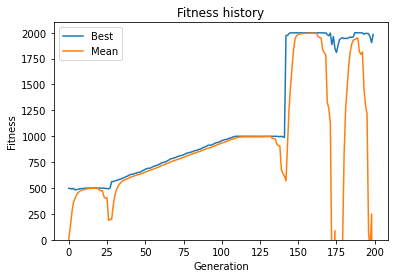

In [78]:
hist, last_population = evolver.evolve(200) 

plt.plot(hist.max(axis=1))
plt.plot(hist.mean(axis=1))

plt.legend(["Best", "Mean"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness history")
plt.ylim(0, 2100)

plt.show()

Now, we managed to achieve both peak of fitness 1000 and peak of fitness 2000:

![After refinement fitness](Example3-Figure3.jpg)

Notice how the average fitness comes closer to the best fitness in the generations just before the falls: this is one of the effects of refinement.

Now, these drops occur as the mutation range is increased, which allows individuals to go further from the population mean, for both better and worse solutions. Although it has this side effect, increasing the mutation range allowed our algorithm to reach other maximums.